<a href="https://colab.research.google.com/github/promaprogga/Protein_Secondary_Structure/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np                                     
import pandas as pd                                   
import copy                                            
from sklearn.model_selection import train_test_split   
from sklearn.svm import SVC                            
from sklearn.metrics import classification_report     
from sklearn import metrics                           
from sklearn.model_selection import GridSearchCV  
import matplotlib.pyplot as plt     

# Data Processing

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset/Protein/archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Dataset/Protein/archive/2018-06-06-pdb-intersect-pisces.csv
/content/drive/MyDrive/Dataset/Protein/archive/2018-06-06-ss.cleaned.csv


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Protein/archive/2018-06-06-pdb-intersect-pisces.csv')
df.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa,Exptl.,resolution,R-factor,FreeRvalue
0,1FV1,F,NPVVHFFKNIVTPRTPPPSQ,CCCCCBCCCCCCCCCCCCCC,CCCCCECCCCCCCCCCCCCC,20,False,XRAY,1.90,0.23,0.27
1,1LM8,H,DLDLEMLAPYIPMDDDFQLR,CCCCCCCCCBCCSCCCEECC,CCCCCCCCCECCCCCCEECC,20,False,XRAY,1.85,0.20,0.24
2,1O06,A,EEDPDLKAAIQESLREAEEA,CCCHHHHHHHHHHHHHHHTC,CCCHHHHHHHHHHHHHHHCC,20,False,XRAY,1.45,0.19,0.22
3,1QOW,D,CTFTLPGGGGVCTLTSECI*,CCTTSCTTCSSTTSSTTCCC,CCCCCCCCCCCCCCCCCCCC,20,True,XRAY,1.06,0.14,1.00
4,1RDQ,I,TTYADFIASGRTGRRNAIHD,CHHHHHHTSSCSSCCCCEEC,CHHHHHHCCCCCCCCCCEEC,20,False,XRAY,1.26,0.13,0.16


In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Dataset/Protein/archive/2018-06-06-ss.cleaned.csv')
df.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
0,1A30,C,EDL,CBC,CEC,3,False
1,1B05,B,KCK,CBC,CEC,3,False
2,1B0H,B,KAK,CBC,CEC,3,False
3,1B1H,B,KFK,CBC,CEC,3,False
4,1B2H,B,KAK,CBC,CEC,3,False


In [ ]:
maxlen_seq = 128
input_seqs, target_seqs = df[['seq', 'sst8']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
#input_grams = seq2ngrams(input_seqs)
print(input_seqs[0:5])
print(target_seqs[0:5])
print(target_seqs.size)

['EDL' 'KCK' 'KAK' 'KFK' 'KAK']
['CBC' 'CBC' 'CBC' 'CBC' 'CBC']
88751


In [ ]:
for row in range(len(target_seqs)):
    secondary_lenth = len(target_seqs[row])
    primary_lenth = len(input_seqs[row])
    
    if(secondary_lenth != primary_lenth):
        print("(",row,") Secondary_Structure ->", target_seqs[row]," Primary_Structure -> ",input_seqs[row])


secondary_count = 0
primary_count = 0
for row in range(len(target_seqs)):
    secondary_lenth = len(target_seqs[row])
    primary_lenth = len(input_seqs[row])
    secondary_count = secondary_count + secondary_lenth
    primary_count = primary_count + primary_lenth
    if(secondary_lenth != primary_lenth):
        print("(",row,") Secondary_Structure ->", target_seqs[row]," Primary_Structure -> ",input_seqs[row])
        
print("count of secondary structure : ",secondary_count)
print("count of primary structure : ",primary_count)

count of secondary structure :  7143303
count of primary structure :  7143303


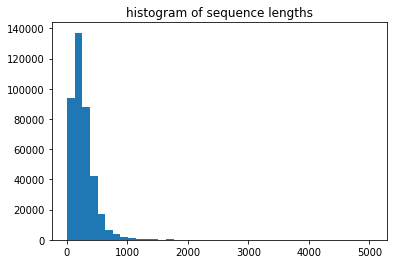

In [ ]:
plt.hist(x='len',data=df,bins=40,histtype='bar');
plt.title('histogram of sequence lengths');

# Labeling target


In [ ]:
def split(sequence): 
    return [char for char in sequence]

primary_split = []
secondary_split = []
for row in range(int(len(target_seqs)/40)):
    primary_split.append(split(input_seqs[row]))
    secondary_split.append(split(target_seqs[row]))

In [ ]:
def orthogonal_primary(arg):
    switch = {
        'A' : np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),  # 20 amino acids
        'C' : np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'E' : np.array([0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'D' : np.array([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'G' : np.array([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'F' : np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'I' : np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]),
        'H' : np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]),
        'K' : np.array([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]),
        'M' : np.array([0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]),
        'L' : np.array([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]),
        'N' : np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]),
        'Q' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]),
        'P' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]),
        'S' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]),
        'R' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]),
        'T' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]),
        'W' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]),
        'V' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]),
        'Y' : np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1])
    }
    
    return switch.get(arg)

def orthogonal_secondary(arg):
    switch = {
        'H' : 0,                    # H= α-helix
        'C' : 1,                    # C= Loops and irregular elements
        'E' : 2,                    # E= β-strand
        'B' : 3,                    # B= β-bridge
        'G' : 4,                    # G= 3-helix
        'I' : 5,                    # I= π-helix
        'T' : 6,                    # T= Turn
        'S' : 7                     # S= Bend
    }
    
    return switch.get(arg)

In [ ]:
print(primary_split[0:5])
print(secondary_split[0:5])

[['E', 'D', 'L'], ['K', 'C', 'K'], ['K', 'A', 'K'], ['K', 'F', 'K'], ['K', 'A', 'K']]
[['C', 'B', 'C'], ['C', 'B', 'C'], ['C', 'B', 'C'], ['C', 'B', 'C'], ['C', 'B', 'C']]


In [ ]:
for row in range(len(primary_split)):  
    sequence = primary_split[row]
    for col in range(len(sequence)):
        # print(sequence[col])
        sequence[col] = orthogonal_primary(sequence[col])
        # print(sequence[col])

In [ ]:
for row in range(len(secondary_split)):  
    sequenceS = secondary_split[row]
    for col in range(len(sequenceS)):
        sequenceS[col] = orthogonal_secondary(sequenceS[col])

In [ ]:
print(primary_split[0:5])
print(secondary_split[0:5])

[[array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])], [array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])], [array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])], [array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])], [array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0,

# Graph


In [ ]:
def graph_sum2(seq1,seq2):
    result = [None]*len(seq1)
    for col in range(len(seq1)):
        result[col] =  seq1[col]+seq2[col]
     

    return result


def graph_sum3(seq1,seq2,seq3):
    result = [None]*len(seq1)
    for col in range(len(seq1)):
        result[col] =  seq1[col]+seq2[col]+seq3[col]
    return result

In [ ]:
graph_input = copy.deepcopy(primary_split)
for row in range(len(primary_split)):
    sequence = primary_split[row]
    graph_input[row][0]=graph_sum2(sequence[0],sequence[1])
    graph_input[row][len(sequence)-1]=graph_sum2(sequence[len(sequence)-1],sequence[len(sequence)-2])
    for col in range(1,len(sequence)-1):
        graph_input[row][col] = graph_sum3(sequence[col-1],sequence[col],sequence[col+1])
        
graph_input[0:5]

[[[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]

In [ ]:
def targetY(data_list):
    Y = []
    for i in range(len(data_list)):
        for j  in range(len(data_list[i])):
            Y.append(data_list[i][j])
            # print(Y[0])
    return Y

In [ ]:
y_label = targetY(secondary_split)

In [ ]:
print(len(y_label))
print(y_label[0:5])

15826
[1, 3, 1, 1, 3]


In [ ]:
def window_padding_data(size, sequence):
    num = int(size/2)
    #print("initial :",sequence[0])
    #print("")
    zeros = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    for i in range(len(sequence)):
        for j in range(num):
            sequence[i].append(zeros)
            sequence[i].insert(0, zeros)
            # print(sequence[i])
            #print("")
            
    X = []
    temp = []

    for k in range(len(sequence)):
        #print(sequence[k])
        for l in range(len(sequence[k])-(size-1)):
            temp = sequence[k][l:l+size]
           # print(temp)
            X.append(temp)
            temp = []

    return X

# Reshape

In [ ]:
X = window_padding_data(11,graph_input)
len(X)
X[0:5]

[[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0,

In [ ]:
np.set_printoptions(threshold=np.inf)
X = np.array(X)
y_label = np.array(y_label)
X = X.reshape(len(X),11*20)
print(X[0:5])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 

In [ ]:
#split the dataset into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size = 0.20,random_state=54)
# print(X_train[0])


# SVM for classification

In [ ]:
#Radial Basis Funtion
svc = SVC(kernel='rbf', gamma = 0.1, C=1.5)
svc.fit(X_train, y_train)
print(X_test[0])
print(X_test[0].shape)
y_pred = svc.predict(X_test)
print(y_pred[0])

# print(y_pred.shape)
y_true = y_test
#    print("i = ",i,"acc = ",metrics.accuracy_score(y_test, y_pred))
print("Accuracy = ",metrics.accuracy_score(y_test, y_pred)*100)
# print(classification_report(y_true,y_pred))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
(220,)
2
Accuracy =  89.73468098547063


In [ ]:
# y_pred = svc.predict(X_test)
print(X_test.shape)
print(y_test.shape)
print(y_pred[:5])
print(y_test[:5])

# print(y_pred.shape)
y_true = y_test
#    print("i = ",i,"acc = ",metrics.accuracy_score(y_test, y_pred))
print("Accuracy = ",metrics.accuracy_score(y_test, y_pred)*100)
# print(classification_report(y_true,y_pred))

(3166, 220)
(3166,)
[2 1 1 1 1]
[2 2 1 1 1]
Accuracy =  89.73468098547063


In [ ]:
EPSILON = 1e-10
print('Mean Absolute Error(MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error(MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error(RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Relative Absolute Error(RAE):', np.sum(np.abs(y_test - y_pred)) / (np.sum(np.abs(y_test - np.mean(y_test))) + EPSILON))
print('Root Relative Squared Error(RRSE):', np.sqrt(np.sum(np.square(y_test - y_pred)) / np.sum(np.square(y_test - np.mean(y_test)))))

Mean Absolute Error(MAE): 0.3044851547694251
Mean Squared Error(MSE): 1.3676563487049904
Root Mean Squared Error(RMSE): 1.1694684043209507
Relative Absolute Error(RAE): 0.25983685915215504
Root Relative Squared Error(RRSE): 0.6744857697237014


# Cross validation

In [ ]:
def evaluate_model(cv):
    scores = cross_val_score(svc, X, y_label, scoring='accuracy', cv=cv, n_jobs=-1)
    return np.mean(scores), scores.min(), scores.max()

# Test

In [ ]:
inputvalue = ['SLLKKLLLA']
actualoutput = ['CHHHHHHHC']

input_split = []
output_split = []
input_split.append(split(inputvalue[0]))
output_split.append(split(actualoutput[0]))
print(input_split)

[['S', 'L', 'L', 'K', 'K', 'L', 'L', 'L', 'A']]


In [ ]:
chain = input_split[0]
for col in range(len(chain)):
    chain[col] = orthogonal_primary(chain[col])
    

chainS = output_split[0]
for col in range(len(chainS)):
    chainS[col] = orthogonal_secondary(chainS[col])
print(input_split)

[[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]]


In [ ]:
g_input = copy.deepcopy(input_split)
for row in range(len(input_split)):
    chain = input_split[row]
    g_input[row][0]=graph_sum2(chain[0],chain[1])
    g_input[row][len(chain)-1]=graph_sum2(chain[len(chain)-1],chain[len(chain)-2])
    for col in range(1,len(chain)-1):
        g_input[row][col] = graph_sum3(chain[col-1],chain[col],chain[col+1])
        
print(g_input)

[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]


In [ ]:
actualY = targetY(output_split)

In [ ]:
input_X = window_padding_data(11,g_input)
input_X = np.array(input_X)
actualY = np.array(actualY)
input_X = input_X.reshape(len(input_X),11*20)
print(input_X)


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 

In [ ]:
pred_output = svc.predict(input_X)
print("Actual     :",actualY)
print("Prediction :",pred_output)

Actual     : [1 0 0 0 0 0 0 0 1]
Prediction : [1 0 0 0 0 0 0 1 1]
